# Value Function Training Algorithm for AMM

## Model Architecture
- Neural network with 3 input nodes (p, x, y)
- 3 hidden layers with 64 nodes each and ReLU activation
- 1 output node (value)
- Uses both main network and target network for stable training

## Parameters
- L: Constant product parameter (L² = x*y)
- γ: Fee rate (0.003)
- σ: Price volatility (0.5)
- δt: Time step (1)
- μ: Price drift (0.0)
- Fee model: 'distribute'
- Fee source: 'incoming' or 'outgoing'

## Training Process

### For each epoch:
1. Generate training data:
   - Sample x values uniformly from [50, 150]
   - Calculate y = L²/x
   - Calculate price bounds: p_min = (y/x)(1-γ), p_max = (y/x)/(1-γ)
   - Sample p values uniformly between bounds

2. For each batch:

   a. Calculate target values:
      - Use Gauss-Legendre quadrature (50 points) for numerical integration
      - For each state (p,x,y):
        * Generate future price points using log-normal distribution
        * Calculate new (x,y) positions based on AMM mechanics
        * Compute future values using target network
        * Calculate expected value through numerical integration
         $$
         E[V(p')] = \sum_{i}^{50} w_i \cdot V(p'_i) \cdot f(p'_i \mid p)
         $$

         where:
         - $w_i$ are the Gauss-Legendre weights
         - $V(p'_i)$ is the value function at future price $p'_i$
         - $f(p'_i \mid p)$ is the log-normal PDF:

   b. Update main network:
      - Forward pass to get predicted values
      - Calculate MSE loss
      - Backpropagate and update weights
      - Clip gradients at norm 1.0

   c. Update target network:
      - Soft update with τ = 0.0005
      - θ_target = τ*θ_current + (1-τ)*θ_target

3. Adjust learning rate:
   - Decay by factor 0.95 every 10 epochs

### Training Configuration
- Number of epochs: 200
- Batch size: 64
- Initial learning rate: 0.0001
- Samples per epoch: 500


In [1]:
import numpy as np





In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import logging
from scipy.stats import norm
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ValueFunctionNN(nn.Module):
    def __init__(self, L=1000, hidden_dim=64, normalize=True):
        super(ValueFunctionNN, self).__init__()
        self.normalize = normalize
        self.L = L
        
        # Neural network layers
        self.network = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def normalize_input(self, state):
        if not self.normalize:
            return state
            
        normalized = torch.zeros_like(state)
        normalized[:, 1] = state[:, 1] / self.L
        normalized[:, 2] = state[:, 2] / self.L
        return normalized
    
    def forward(self, state):
        # Normalize the input state
        normalized_state = self.normalize_input(state)
        # Process through the network
        return self.network(normalized_state)

def load_model(model_path, L, device='cuda'):
    """
    Load a trained model with proper error handling
    
    Args:
        model_path: Path to the model file
        device: Device to load the model on
    
    Returns:
        Loaded model or None if loading failed
    """
    try:
        # Check if file exists
        if not os.path.exists(model_path):
            print(f"Model file not found: {model_path}")
            return None
        
        # Create a new model instance
        model = ValueFunctionNN(L=L).to(device)
        
        # Load only the state dictionary (fixes the FutureWarning)
        state_dict = torch.load(model_path, map_location=torch.device(device), weights_only=True)
        model.load_state_dict(state_dict)
        
        # Set to evaluation mode
        model.eval()
        return model
    
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        return None
# Function to generate test states across the entire valid state space
def generate_test_data(L, num_samples):
    """
    Generate test data with price p fixed at price ratio y/x
    
    Args:
        num_samples: Number of samples to generate
        
    Returns:
        Tensor of shape (num_samples, 3) containing (p, x, y)
    """
    # Generate x values using Gauss-Legendre points for better coverage
    min_x = L*0.95
    max_x = L*1.05
    x_values = torch.linspace(min_x, max_x, num_samples)
        
    # Calculate corresponding y values using constant product formula
    y_values = L**2 / x_values
        
    # Set price exactly at the price ratio (p = y/x)
    p_values = y_values / x_values
    
    # Stack into a single array and move to device
    states = torch.stack([p_values, x_values, y_values], dim=1)
    
    return states

# Function to calculate immediate reward
def immediate_reward(state):
    p, x, y = state
    return p * x + y

def calculate_fee_ingoing(L, gamma, sigma, delta_t, p, x, y):
    """
    Calculate expected ingoing fee for distribute model
    """
    alpha = L * np.sqrt((1-gamma) * p) * np.exp(-sigma**2 * delta_t / 8)
        
    d1 = np.log((1-gamma)*y/(p*x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t))
        
    term1 = alpha * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = p*x * norm.cdf(d1 - 0.5*sigma*np.sqrt(delta_t))
    term3 = y * norm.cdf(-d2 - 0.5*sigma*np.sqrt(delta_t))
        
    return (gamma/(1-gamma)) * (term1 - term2 - term3)

def calculate_fee_outgoing(L, gamma, sigma, delta_t, p, x, y):
    """
    Calculate expected outgoing fee
    """
    alpha = L * np.sqrt((1-gamma) * p) * np.exp(-sigma**2 * delta_t / 8)
        
    d1 = np.log((1-gamma)*y/(p*x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t))
        
    term1 = alpha * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = p*x * norm.cdf(-d2 + 0.5*sigma*np.sqrt(delta_t))
    term3 = y * norm.cdf(d1 + 0.5*sigma*np.sqrt(delta_t))
        
    return gamma * (-term1 + term2 + term3)



In [3]:
import pandas as pd
import torch
import numpy as np
import os
from tqdm import tqdm

def eval_model(gamma_list,
               sigma_list,
               fee_source_list,
               fee_model_list,
               L=10000,
               delta_t=1,
               num_samples=500,
               device='cuda'):
    """
    Evaluate models across different parameter combinations
    
    Args:
        gamma_list: List of gamma values to evaluate
        sigma_list: List of sigma values to evaluate
        fee_source_list: List of fee sources to evaluate
        fee_model_list: List of fee models to evaluate
        L: Constant product parameter
        delta_t: Time step
        num_samples: Number of test samples
        device: Device to run evaluation on
    
    Returns:
        DataFrame containing evaluation results
    """
    root_dir = '/home/shiftpub/Dynamic_AMM/models'  # Updated folder name
    model_name = 'optimal_mc_value_network_'
    results = []
    
    # Generate test data once
    test_states = generate_test_data(L=L, num_samples=num_samples).to(device)
    
    # Calculate immediate rewards for all test states at once
    immediate_rewards = torch.tensor([immediate_reward(state) for state in test_states])
    
    # Create a progress bar for the total number of model evaluations
    total_evals = len(fee_source_list) * len(fee_model_list) * len(gamma_list) * len(sigma_list)
    pbar = tqdm(total=total_evals, desc="Evaluating models")
    
    # Create results directory if it doesn't exist
    results_dir = os.path.join(os.getcwd(), 'evaluation_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Keep track of processed models to save partial results
    processed_count = 0
    
    for fee_source in fee_source_list:
        for fee_model in fee_model_list:
            for gamma in gamma_list:
                for sigma in sigma_list:
                    # Construct model path
                    model_path = f'{root_dir}/{model_name}{fee_model}_{fee_source}_gamma_{gamma}_sigma_{sigma}.pth'
                    
                    # Load model
                    model = load_model(model_path, L, device=device)
                    if model is None:
                        # Skip this combination if model loading failed
                        pbar.update(1)
                        continue
                    
                    # Evaluate all test states at once
                    with torch.no_grad():
                        values = model(test_states).squeeze().cpu().numpy()
                    
                    # Process each test state
                    for i, state in enumerate(test_states):
                        p_val, x_val, y_val = state.cpu().tolist()
                        imm_reward = immediate_rewards[i].item()
                        
                        # Calculate fee based on fee source
                        if fee_source == 'incoming':
                            fee = calculate_fee_ingoing(L, gamma, sigma, delta_t, p_val, x_val, y_val)
                        else:
                            fee = calculate_fee_outgoing(L, gamma, sigma, delta_t, p_val, x_val, y_val)
                        
                        # Store results
                        results.append({
                            'state_idx': i,
                            'gamma': gamma,
                            'sigma': sigma,
                            'fee_source': fee_source,
                            'fee_model': fee_model,
                            'p': p_val,
                            'x': x_val,
                            'y': y_val,
                            'immediate_reward': imm_reward,
                            'fee': fee,
                            'value': values[i],
                        })
                    
                    # Update progress bar
                    pbar.update(1)
                    processed_count += 1
                    
                    # Save partial results every 10 models
                    if processed_count % 10 == 0:
                        partial_df = pd.DataFrame(results)
                        partial_df.to_csv(f'{results_dir}/partial_results_{processed_count}.csv', index=False)
    
    # Close progress bar
    pbar.close()
    
    # Convert results to DataFrame
    df = pd.DataFrame(results)
    
    # Save full results
    df.to_csv(f'{results_dir}/full_evaluation_results.csv', index=False)
    
    return df

In [4]:
gammas = [0.0005, 0.005, 0.05, 0.5]
sigmas = [0.1, 0.5, 1, 2]
fee_sources = ['incoming', 'outgoing']
fee_models = ['distribute']
L = 1000

df = eval_model(gamma_list=gammas, sigma_list=sigmas, fee_source_list=fee_sources, fee_model_list=fee_models, L=L)


Evaluating models: 100%|██████████| 32/32 [00:02<00:00, 15.26it/s]


In [5]:
filtered_df = df[(df['gamma'] == 0.5) & (df['fee_source'] == 'outgoing')]

print(filtered_df.head().to_markdown())

|       |   state_idx |   gamma |   sigma | fee_source   | fee_model   |       p |       x |       y |   immediate_reward |         fee |   value |
|------:|------------:|--------:|--------:|:-------------|:------------|--------:|--------:|--------:|-------------------:|------------:|--------:|
| 14000 |           0 |     0.5 |     0.1 | outgoing     | distribute  | 1.10803 | 950     | 1052.63 |            2105.26 | 1.56969e-09 | 1165.66 |
| 14001 |           1 |     0.5 |     0.1 | outgoing     | distribute  | 1.10757 | 950.2   | 1052.41 |            2104.82 | 1.56936e-09 | 1165.59 |
| 14002 |           2 |     0.5 |     0.1 | outgoing     | distribute  | 1.1071  | 950.401 | 1052.19 |            2104.38 | 1.56903e-09 | 1165.52 |
| 14003 |           3 |     0.5 |     0.1 | outgoing     | distribute  | 1.10663 | 950.601 | 1051.97 |            2103.93 | 1.5687e-09  | 1165.45 |
| 14004 |           4 |     0.5 |     0.1 | outgoing     | distribute  | 1.10617 | 950.802 | 1051.74 |          

In [6]:
print(df.sigma.unique())

[0.1 0.5 1.  2. ]


In [7]:
print(df.head().to_markdown())

|    |   state_idx |   gamma |   sigma | fee_source   | fee_model   |       p |       x |       y |   immediate_reward |       fee |   value |
|---:|------------:|--------:|--------:|:-------------|:------------|--------:|--------:|--------:|-------------------:|----------:|--------:|
|  0 |           0 |  0.0005 |     0.1 | incoming     | distribute  | 1.10803 | 950     | 1052.63 |            2105.26 | 0.0202097 | 1196.65 |
|  1 |           1 |  0.0005 |     0.1 | incoming     | distribute  | 1.10757 | 950.2   | 1052.41 |            2104.82 | 0.0202054 | 1196.57 |
|  2 |           2 |  0.0005 |     0.1 | incoming     | distribute  | 1.1071  | 950.401 | 1052.19 |            2104.38 | 0.0202012 | 1196.49 |
|  3 |           3 |  0.0005 |     0.1 | incoming     | distribute  | 1.10663 | 950.601 | 1051.97 |            2103.93 | 0.0201969 | 1196.4  |
|  4 |           4 |  0.0005 |     0.1 | incoming     | distribute  | 1.10617 | 950.802 | 1051.74 |            2103.49 | 0.0201926 | 1196.32 |

In [8]:
# Calculate mean values for each combination of gamma and sigma
value_table = pd.pivot_table(df, 
                           values='value', 
                           index='gamma',
                           columns='sigma', 
                           aggfunc='mean')

fee_table = pd.pivot_table(df, 
                         values='fee', 
                         index='gamma',
                         columns='sigma', 
                         aggfunc='mean')

# Print the tables
print("Average Value Table (rows: fee rate, columns: sigma)")
print("=" * 60)
print(value_table.to_markdown(floatfmt=".4f"))
print("\n")

print("Average Fee Table (rows: fee rate, columns: sigma)")
print("=" * 60)
print(fee_table.to_markdown(floatfmt=".4f"))

Average Value Table (rows: fee rate, columns: sigma)
|   gamma |       0.1 |       0.5 |       1.0 |       2.0 |
|--------:|----------:|----------:|----------:|----------:|
|  0.0005 | 1180.1158 | 1178.3062 | 1225.0457 | 1185.0985 |
|  0.0050 | 1207.1710 | 1217.2853 | 1194.5635 | 1195.2179 |
|  0.0500 | 1203.2709 | 1228.0328 | 1228.2808 | 1202.5227 |
|  0.5000 | 1202.6100 | 1192.0449 | 1224.6262 | 1211.7748 |


Average Fee Table (rows: fee rate, columns: sigma)
|   gamma |    0.1 |     0.5 |      1.0 |      2.0 |
|--------:|-------:|--------:|---------:|---------:|
|  0.0005 | 0.0200 |  0.0988 |   0.1917 |   0.3417 |
|  0.0050 | 0.1998 |  0.9899 |   1.9195 |   3.4199 |
|  0.0500 | 1.7740 | 10.0166 |  19.4598 |  34.5160 |
|  0.5000 | 0.0000 | 41.4874 | 171.6130 | 361.0274 |


In [9]:
print(df.columns)

Index(['state_idx', 'gamma', 'sigma', 'fee_source', 'fee_model', 'p', 'x', 'y',
       'immediate_reward', 'fee', 'value'],
      dtype='object')


In [10]:
# Create a pivot table comparing values across all dimensions
value_comparison = pd.pivot_table(df, 
                                values='value',
                                index=['gamma', 'fee_source'],
                                columns='sigma',
                                aggfunc='mean')

print("Average Value Table (rows: fee rate & fee source, columns: sigma)")
print("=" * 80)
print(value_comparison.to_markdown(floatfmt=".4f"))



# Calculate and display some summary statistics
summary_stats = df.groupby(['fee_source', 'gamma', 'sigma'])['value'].agg(['mean', 'std', 'min', 'max']).round(4)
print("\nSummary Statistics:")
print("=" * 80)
print(summary_stats.to_markdown())

Average Value Table (rows: fee rate & fee source, columns: sigma)
|                      |       0.1 |       0.5 |       1.0 |       2.0 |
|:---------------------|----------:|----------:|----------:|----------:|
| (0.0005, 'incoming') | 1178.3070 | 1167.4285 | 1245.6482 | 1173.0137 |
| (0.0005, 'outgoing') | 1181.9249 | 1189.1838 | 1204.4430 | 1197.1835 |
| (0.005, 'incoming')  | 1182.9272 | 1180.4128 | 1185.8079 | 1177.8160 |
| (0.005, 'outgoing')  | 1231.4148 | 1254.1576 | 1203.3191 | 1212.6199 |
| (0.05, 'incoming')   | 1170.6820 | 1217.3147 | 1188.5778 | 1167.2549 |
| (0.05, 'outgoing')   | 1235.8599 | 1238.7510 | 1267.9839 | 1237.7908 |
| (0.5, 'incoming')    | 1255.2548 | 1179.2264 | 1262.3944 | 1278.3181 |
| (0.5, 'outgoing')    | 1149.9651 | 1204.8634 | 1186.8580 | 1145.2314 |

Summary Statistics:
|                           |    mean |     std |     min |     max |
|:--------------------------|--------:|--------:|--------:|--------:|
| ('incoming', 0.0005, 0.1) | 1178.31 | 10.

In [11]:
def calculate_fee_ingoing(L, gamma, sigma, delta_t, p, x, y):
    """
    Calculate expected ingoing fee for distribute model
    """
    alpha = L * np.sqrt((1-gamma) * p) * np.exp(-sigma**2 * delta_t / 8)
    d1 = np.log((1-gamma)*y/(p*x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t))
    term1 = alpha * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = p*x * norm.cdf(d1 - 0.5*sigma*np.sqrt(delta_t))
    term3 = y * norm.cdf(-d2 - 0.5*sigma*np.sqrt(delta_t))
    return (gamma/(1-gamma)) * (term1 - term2 - term3)

In [12]:
gamma = 0.0005
sigma = 1
delta_t = 1
p = 1.10803
x = 950
y = 1052.63
print(f"ingoing: {calculate_fee_ingoing(L, gamma, sigma, delta_t, p, x, y)}")
print(f"outgoing: {calculate_fee_outgoing(L, gamma, sigma, delta_t, p, x, y)}")

ingoing: 0.13964945211013405
outgoing: 0.2634983002968815


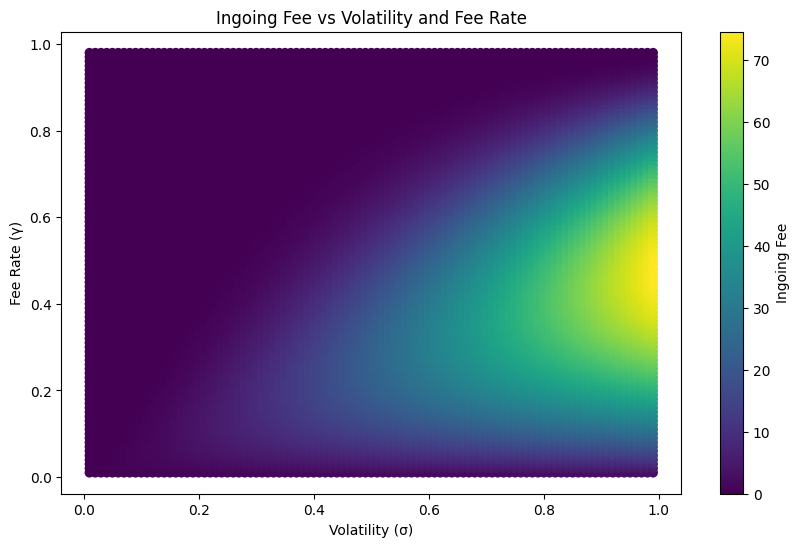

|    |   sigma |   gamma |     ingoing |    outgoing |
|---:|--------:|--------:|------------:|------------:|
|  0 |    0.01 |    0.01 | 0.00871277  | 0.042059    |
|  1 |    0.01 |    0.02 | 0.0017077   | 0.020152    |
|  2 |    0.01 |    0.03 | 0.000104005 | 0.00233546  |
|  3 |    0.01 |    0.04 | 2.12551e-06 | 7.88106e-05 |
|  4 |    0.01 |    0.05 | 1.43159e-08 | 7.99386e-07 |


In [13]:
results = []
for sigma in np.arange(0.01, 1, 0.01):
    for gamma in np.arange(0.01, 0.99, 0.01):
        p = 1.10803
        x = 950
        y = 1052.63
        ingoing = calculate_fee_ingoing(L, gamma, sigma, delta_t, p, x, y)
        outgoing = calculate_fee_outgoing(L, gamma, sigma, delta_t, p, x, y)
        results.append({'sigma': sigma, 'gamma': gamma, 'ingoing': ingoing, 'outgoing': outgoing})
        
results = pd.DataFrame(results)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results['sigma'], results['gamma'], c=results['ingoing'], cmap='viridis')
plt.colorbar(label='Ingoing Fee')
plt.xlabel('Volatility (σ)')
plt.ylabel('Fee Rate (γ)')
plt.title('Ingoing Fee vs Volatility and Fee Rate')
plt.show()

print(results.head().to_markdown())

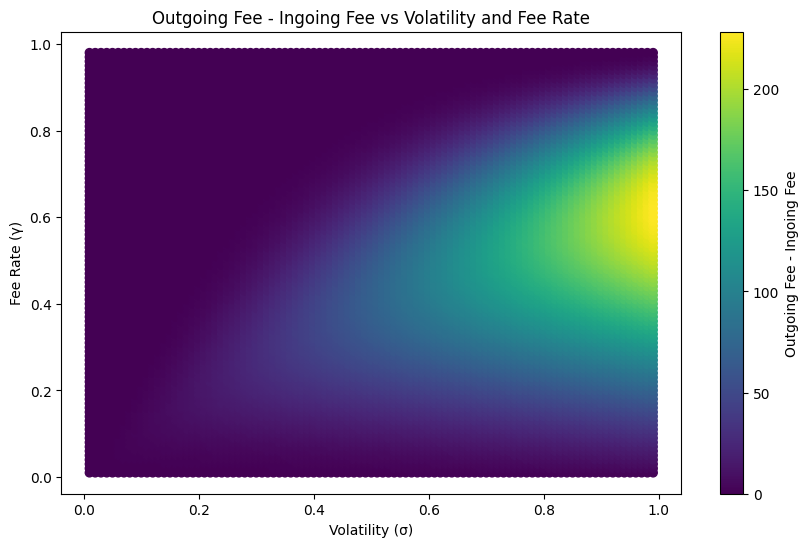

In [14]:
# plot outgoing fee - ingoing fee
plt.figure(figsize=(10, 6))
plt.scatter(results['sigma'], results['gamma'], c=results['outgoing'] - results['ingoing'], cmap='viridis')
plt.colorbar(label='Outgoing Fee - Ingoing Fee')
plt.xlabel('Volatility (σ)')
plt.ylabel('Fee Rate (γ)')
plt.title('Outgoing Fee - Ingoing Fee vs Volatility and Fee Rate')
plt.show()


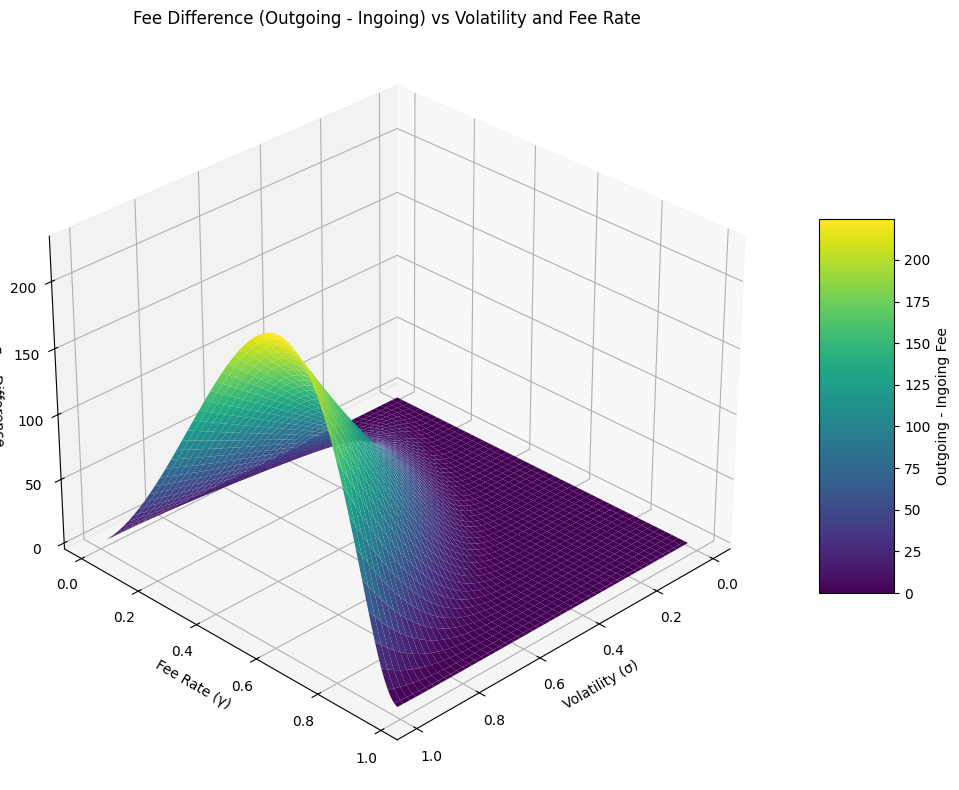


Fee Difference Statistics:
|                |   Min |     Max |    Mean |     Std |
|:---------------|------:|--------:|--------:|--------:|
| Fee Difference |     0 | 228.431 | 41.9216 | 54.5111 |


In [15]:
# Create 3D plot
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
sigma_unique = results['sigma'].unique()
gamma_unique = results['gamma'].unique()
X, Y = np.meshgrid(sigma_unique, gamma_unique)
Z = np.zeros((len(gamma_unique), len(sigma_unique)))

for i, gamma in enumerate(gamma_unique):
    for j, sigma in enumerate(sigma_unique):
        mask = (results['sigma'] == sigma) & (results['gamma'] == gamma)
        if any(mask):
            Z[i,j] = results.loc[mask, 'outgoing'].values[0] - results.loc[mask, 'ingoing'].values[0]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', 
                      linewidth=0, antialiased=True)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Outgoing - Ingoing Fee')

# Set labels and title
ax.set_xlabel('Volatility (σ)')
ax.set_ylabel('Fee Rate (γ)')
ax.set_zlabel('Fee Difference')
ax.set_title('Fee Difference (Outgoing - Ingoing) vs Volatility and Fee Rate')

# Adjust the viewing angle for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Print some statistics about the fee differences
print("\nFee Difference Statistics:")
print("=========================")
diff = results['outgoing'] - results['ingoing']
stats = pd.DataFrame({
    'Min': diff.min(),
    'Max': diff.max(),
    'Mean': diff.mean(),
    'Std': diff.std()
}, index=['Fee Difference'])
print(stats.to_markdown())

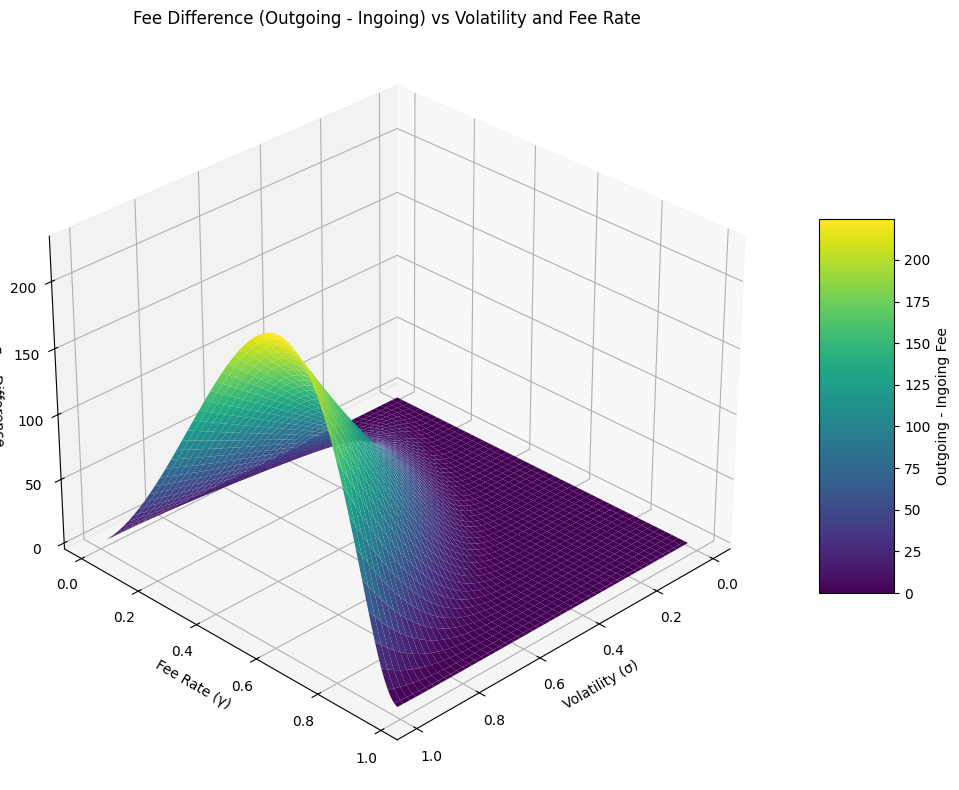


Fee Difference Statistics:
|                |   Min |     Max |    Mean |     Std |
|:---------------|------:|--------:|--------:|--------:|
| Fee Difference |     0 | 228.431 | 41.9216 | 54.5111 |


In [16]:
# Create 3D plot
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
sigma_unique = results['sigma'].unique()
gamma_unique = results['gamma'].unique()
X, Y = np.meshgrid(sigma_unique, gamma_unique)
Z = np.zeros((len(gamma_unique), len(sigma_unique)))

for i, gamma in enumerate(gamma_unique):
    for j, sigma in enumerate(sigma_unique):
        mask = (results['sigma'] == sigma) & (results['gamma'] == gamma)
        if any(mask):
            Z[i,j] = results.loc[mask, 'outgoing'].values[0] - results.loc[mask, 'ingoing'].values[0]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', 
                      linewidth=0, antialiased=True)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Outgoing - Ingoing Fee')

# Set labels and title
ax.set_xlabel('Volatility (σ)')
ax.set_ylabel('Fee Rate (γ)')
ax.set_zlabel('Fee Difference')
ax.set_title('Fee Difference (Outgoing - Ingoing) vs Volatility and Fee Rate')

# Adjust the viewing angle for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Print some statistics about the fee differences
print("\nFee Difference Statistics:")
print("=========================")
diff = results['outgoing'] - results['ingoing']
stats = pd.DataFrame({
    'Min': diff.min(),
    'Max': diff.max(),
    'Mean': diff.mean(),
    'Std': diff.std()
}, index=['Fee Difference'])
print(stats.to_markdown())

In [17]:
print(df.head().to_markdown())

|    |   state_idx |   gamma |   sigma | fee_source   | fee_model   |       p |       x |       y |   immediate_reward |       fee |   value |
|---:|------------:|--------:|--------:|:-------------|:------------|--------:|--------:|--------:|-------------------:|----------:|--------:|
|  0 |           0 |  0.0005 |     0.1 | incoming     | distribute  | 1.10803 | 950     | 1052.63 |            2105.26 | 0.0202097 | 1196.65 |
|  1 |           1 |  0.0005 |     0.1 | incoming     | distribute  | 1.10757 | 950.2   | 1052.41 |            2104.82 | 0.0202054 | 1196.57 |
|  2 |           2 |  0.0005 |     0.1 | incoming     | distribute  | 1.1071  | 950.401 | 1052.19 |            2104.38 | 0.0202012 | 1196.49 |
|  3 |           3 |  0.0005 |     0.1 | incoming     | distribute  | 1.10663 | 950.601 | 1051.97 |            2103.93 | 0.0201969 | 1196.4  |
|  4 |           4 |  0.0005 |     0.1 | incoming     | distribute  | 1.10617 | 950.802 | 1051.74 |            2103.49 | 0.0201926 | 1196.32 |

In [18]:
print(len(df))
print(len(df.state_idx.unique()))

16000
500


In [20]:
# Group by state_idx and compare outgoing vs incoming values
state_comparison = df.pivot_table(
    index=['state_idx', 'gamma', 'sigma'],
    columns='fee_source',
    values='value'
).reset_index()

# Calculate the difference and comparison
state_comparison['value_diff'] = state_comparison['outgoing'] - state_comparison['incoming']
state_comparison['outgoing_higher'] = state_comparison['value_diff'] > 0

# Overall statistics
total_states = len(state_comparison)
outgoing_higher_count = state_comparison['outgoing_higher'].sum()

print(f"Total unique states: {total_states}")
print(f"States where outgoing value is higher: {outgoing_higher_count} ({outgoing_higher_count/total_states*100:.2f}%)")

# Analysis by gamma and sigma
analysis = state_comparison.groupby(['gamma', 'sigma']).agg({
    'outgoing_higher': ['count', 'sum'],
    'value_diff': ['mean', 'std', 'min', 'max']
}).round(4)

# Rename columns for clarity
analysis.columns = ['Total_States', 'Outgoing_Higher_Count', 'Avg_Difference', 'Std_Difference', 'Min_Difference', 'Max_Difference']
analysis['Percentage_Outgoing_Higher'] = (analysis['Outgoing_Higher_Count'] / analysis['Total_States'] * 100).round(2)

print("\nAnalysis by gamma and sigma:")
print("=" * 80)
print(analysis.to_markdown())


Total unique states: 8000
States where outgoing value is higher: 6000 (75.00%)

Analysis by gamma and sigma:
|               |   Total_States |   Outgoing_Higher_Count |   Avg_Difference |   Std_Difference |   Min_Difference |   Max_Difference |   Percentage_Outgoing_Higher |
|:--------------|---------------:|------------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------------------:|
| (0.0005, 0.1) |            500 |                     500 |           3.6178 |           0.3777 |           2.9751 |           4.2802 |                          100 |
| (0.0005, 0.5) |            500 |                     500 |          21.7553 |           0.894  |          20.23   |          23.3234 |                          100 |
| (0.0005, 1.0) |            500 |                       0 |         -41.2052 |           2.414  |         -45.6504 |         -37.3066 |                            0 |
| (0.0005, 2.0) |            500 |                 

In [ ]:
# Group by state_idx and compare outgoing vs incoming values
state_comparison = df.pivot_table(
    index=['state_idx', 'gamma', 'sigma'],
    columns='fee_source',
    values='value'
).reset_index()


print(state_comparison.to_markdown())

In [23]:
(0.95)**(100)

0.0059205292203339975